In [ ]:
#Install Biopython
!pip install biopython


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 17.3 MB/s eta 0:00:00


In [ ]:
import numpy as np                      # For numerical operations and arrays
import pandas as pd                    # For data manipulation and analysis
from collections import Counter        # For counting elements (e.g., nucleotide/k-mer frequencies)
import matplotlib.pyplot as plt        # For creating static plots
import seaborn as sns                  # For advanced visualizations (e.g., heatmaps)
from sklearn.model_selection import train_test_split, cross_val_score  # For data splitting and cross-validation
from sklearn.ensemble import RandomForestClassifier                    # For training a Random Forest model
from sklearn.preprocessing import StandardScaler, OneHotEncoder       # For feature scaling and encoding
from sklearn.feature_extraction.text import CountVectorizer           # For extracting k-mer features from sequences
from Bio import Entrez, SeqIO          # For accessing NCBI and parsing biological sequence data
from flask import Flask, send_file     # For creating a web interface and sending files (if needed)


## 1. Extracting validation test

In [ ]:


Entrez.email = 'ziyard.20210326@iit.ac.lk'

# List of accession numbers
accession_numbers = {
    #japan
     "japan" : ["AP008299.1", "AP008300.1", "AP008301.1", "AP008302.1", "AP008303.1",
         "AP008304.1", "AP008305.1", "AP008306.1", "AP008307.1", "AP008308.1",
         "AP008309.1"],
    #india
    "india" : ["MH444418.1", "MH444419.1", "MH444420.1", "MH444421.1", "MH444422.1",
         "MH444423.1", "MH444424.1", "MH444425.1", "MH444426.1", "MH444427.1",
         "MH444428.1"],
    #russia
     "russia" :["AY519484.2", "AY519485.2", "AY519486.1", "AY519487.2", "AY519488.1",
         "AY519489.2", "AY519490.2", "AY519491.2", "AY519492.2", "AY519493.2",
         "AY519494.2"],
    #spain
     "spain" : ["JX297176.1", "JX297177.1", "JX297178.1", "JX297179.1", "JX297180.1",
         "JX297181.1", "JX297182.1", "JX297183.1", "JX297184.1", "JX297185.1",
         "JX297186.1"],
     "kenya" :  ["AY632952.1", "AY632953.1", "AY632954.1", "AY632955.1", "AY632956.1",
         "AY632957.1", "AY632958.1", "AY632959.1", "AY632960.1", "AY632961.1",
         "AY632962.1"],
    #Burkina Faso (142 to 1226 bases)
    "burkina" : ["MH123288.1", "MH123289.1", "MH123290.1", "MH123291.1", "MH123292.1",
         "MH123293.1", "MH123294.1", "MH123295.1", "MH123296.1", "MH123297.1",
         "MH123298.1"],

}



# Initialize an empty list to hold the sequences
hvr_data = []
geo_loc_counts = {}  # keep track of occurrences for each country
# ethnicity_counts = {"asia": 0, "caucasian": 0, "africa": 0}  # To keep track of ethnicity occurrences

# Define ethnicities based on countries
ethnicity_map = {
    "japan": "asian",
    "india": "asian",
    "russia": "caucasian",
    "spain": "caucasian",
    "kenya": "african",
    "burkina": "african",

}

# Initialize counters for Burkina and Burkina Faso
geo_loc_counts = {"burkina": 0}  # Only track "burkina" count here
burkina_faso_count = 0  # Separate counter for Burkina Faso

# Loop through each accession number
sample_counter = 1  # Initialize a continuous sample counter

for country, accession_numbers in accession_numbers.items():
    if country not in geo_loc_counts:
        geo_loc_counts[country] = 0  # Initialize the counter for the country

    for acc in accession_numbers:
        try:
            # Fetch the GenBank record
            handle = Entrez.efetch(db="nucleotide", id=acc, rettype="gb", retmode="text")
            record = SeqIO.read(handle, "genbank")
            handle.close()

            # Define the indices for HVR1 and HVR2
            if country in ["japan", "india", "russia", "spain", ]:
                hvr1_start, hvr1_end = 16024, 16365
                hvr2_start, hvr2_end = 73, 340
            elif country in ["kenya"]:
                hvr1_start, hvr1_end = 1, 342
                hvr2_start, hvr2_end = 618, 885
            # elif country in ["burkina"]:
            #     hvr1_start, hvr1_end = 142, 483
            #     hvr2_start, hvr2_end = 760, 1027
            elif country in ["burkina"]:
                hvr1_start, hvr1_end = 143, 484
                hvr2_start, hvr2_end = 761, 1028

            # Extract the HVR sequences
            hvr1_sequence = str(record.seq[hvr1_start:hvr1_end])
            hvr2_sequence = str(record.seq[hvr2_start:hvr2_end])

            # Calculate the lengths of HVR1, HVR2, and the concatenated sequence
            hvr1_length = len(hvr1_sequence)
            hvr2_length = len(hvr2_sequence)
            concatenated_length = hvr1_length + hvr2_length

            # Update geo_loc with the current count for the country
            if country == "burkina":
                geo_loc_counts["burkina"] += 1  # Increment the counter for Burkina
                geo_loc = f"burkina{geo_loc_counts['burkina']}"  # Create geo_loc for Burkina


            # # Update geo_loc for Burkina Faso
            # elif country == "burkinaFaso":
            #     burkina_faso_count += 1  # Increment the counter for Burkina Faso
            #     geo_loc = f"burkina{geo_loc_counts['burkina'] + burkina_faso_count}"  # Continue from Burkina count

            # if country in ["burkina", "burkinaFaso"]:
            #     geo_loc = "burkina"

            else:
                geo_loc_counts[country] += 1  # Increment the counter for other countries
                geo_loc = f"{country}{geo_loc_counts[country]}"  # Create geo_loc string
                # geo_loc = country

            # Update ethnicity based on the group
            if country in ["japan", "india"]:
                ethnicity = f"asian"
            elif country in ["russia", "spain"]:
                ethnicity = f"caucasian"
            elif country in ["kenya", "burkina", "burkinaFaso"]:
                ethnicity = f"african"
            else:
                ethnicity = "unknown"  # Fallback in case of an unrecognized country

            # Append the data to the list with lengths
            hvr_data.append({
                "sample": f"sample{sample_counter}",  # Continuous sample number
                "accession": acc,
                "HVR1": hvr1_sequence,
                "HVR2": hvr2_sequence,
                "HVR1_length": hvr1_length,
                "HVR2_length": hvr2_length,
                "concatenated_length": concatenated_length,
                "geo_loc": geo_loc,
                "ethnicity": ethnicity
            })

            # Increment the sample counter
            sample_counter += 1

        except Exception as e:
            print(f"Error processing {acc}: {e}")

In [ ]:
#4
# Save the sequences to a CSV file
df = pd.DataFrame(hvr_data)
output_file = 'hvr_sequences_validation.csv'
df.to_csv(output_file, index=False)

In [ ]:
#Load Dataset
df = pd.read_csv('hvr_sequences_validation.csv')

EXPLORING THE DATASET
1. Basic Dataset Information:
--------------------------------------------------
Total number of sequences: 66

Dataset columns: ['sample', 'accession', 'HVR1', 'HVR2', 'HVR1_length', 'HVR2_length', 'concatenated_length', 'geo_loc', 'ethnicity']

Missing values:
sample                 0
accession              0
HVR1                   0
HVR2                   0
HVR1_length            0
HVR2_length            0
concatenated_length    0
geo_loc                0
ethnicity              0
dtype: int64

2. Sequence Length Analysis:
--------------------------------------------------
Minimum HVR1 length: 341
Maximum HVR1 length: 341
Mean HVR1 length: 341.00
Minimum HVR2 length: 267
Maximum HVR2 length: 267
Mean HVR2 length: 267.00
Minimum concatenated length: 608
Maximum concatenated length: 608
Mean concatenated length: 608.00

4. Ethnicity Distribution:
--------------------------------------------------
ethnicity
asian        22
caucasian    22
african      22
Name: coun

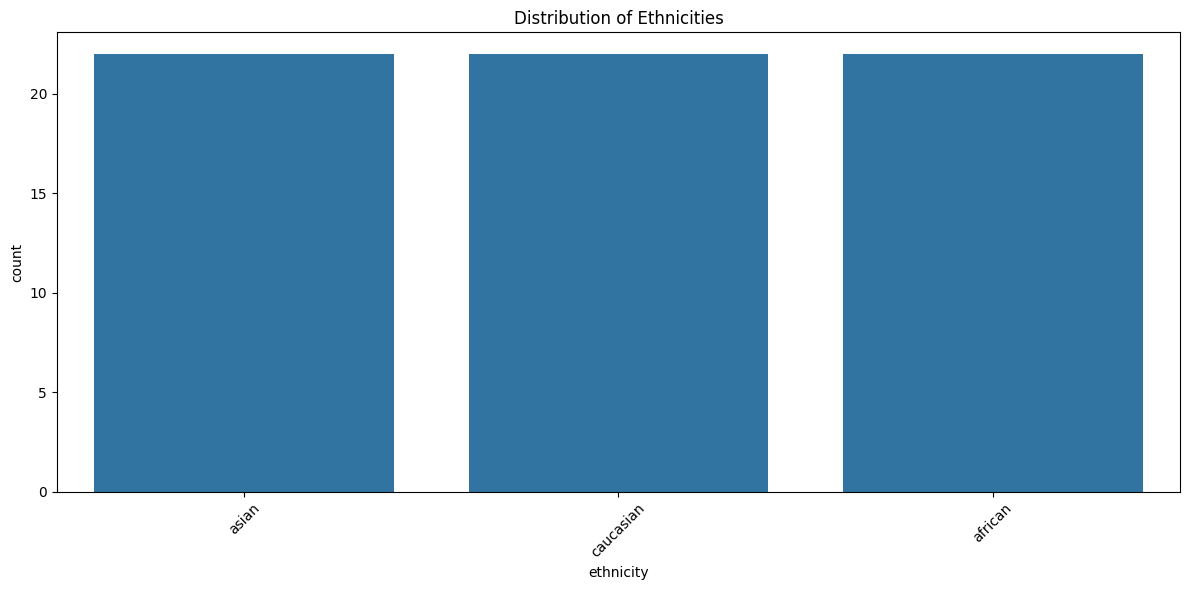


ANALYZING NON-STANDARD BASES
No non-standard bases found.

Verification successful: All non-standard bases were properly replaced with 'N'

Cleaned data saved to 'cleaned_hvr1_hvr2_ethnicity.csv'


In [ ]:
def explore_sequence_data(df):
    """
    Explore and analyze genomic sequence data.
    """
    print("1. Basic Dataset Information:")
    print("-" * 50)
    print(f"Total number of sequences: {len(df)}")
    print("\nDataset columns:", df.columns.tolist())
    print("\nMissing values:")
    print(df.isnull().sum())

    # Sequence columns
    sequence_cols = ['HVR1', 'HVR2']

    print("\n2. Sequence Length Analysis:")
    print("-" * 50)
    print(f"Minimum HVR1 length: {df['HVR1_length'].min()}")
    print(f"Maximum HVR1 length: {df['HVR1_length'].max()}")
    print(f"Mean HVR1 length: {df['HVR1_length'].mean():.2f}")
    print(f"Minimum HVR2 length: {df['HVR2_length'].min()}")
    print(f"Maximum HVR2 length: {df['HVR2_length'].max()}")
    print(f"Mean HVR2 length: {df['HVR2_length'].mean():.2f}")
    print(f"Minimum concatenated length: {df['concatenated_length'].min()}")
    print(f"Maximum concatenated length: {df['concatenated_length'].max()}")
    print(f"Mean concatenated length: {df['concatenated_length'].mean():.2f}")

    #Ethnicity distribution
    print("\n4. Ethnicity Distribution:")
    print("-" * 50)
    print(df['ethnicity'].value_counts())

    # Plot ethnicity distribution
    plt.figure(figsize=(12, 6))
    sns.countplot(data=df, x='ethnicity')
    plt.xticks(rotation=45)
    plt.title('Distribution of Ethnicities')
    plt.tight_layout()
    plt.show()

def analyze_non_standard_bases(df):
    """
    Analyze and process non-standard bases in both HVR1 and HVR2 sequence data.
    Returns a DataFrame with non-standard bases replaced with 'N' if below threshold.
    """
    # Create a copy of the DataFrame to avoid modifying the original
    df_cleaned = df.copy()

    # Sequence columns
    sequence_cols = ['HVR1', 'HVR2']

    # Find unique bases in the dataset for both HVR1 and HVR2
    all_bases = "".join(df_cleaned[sequence_cols].dropna().apply(lambda row: ''.join(row), axis=1))
    base_counts = Counter(all_bases)

    # Identify non-standard bases (excluding A, T, C, G)
    non_standard_bases = {base: count for base, count in base_counts.items() if base not in "ATCG"}

    if not non_standard_bases:
        print("No non-standard bases found.")
        return df_cleaned

    # Calculate total bases
    total_bases = sum(base_counts.values())

    print("\nNon-Standard Base Analysis:")
    print("-" * 50)

    # Store row details with non-standard bases
    non_standard_base_details = {}

    # Step 1: Show rows with non-standard bases and their percentages
    for idx, row in df_cleaned.iterrows():
        non_standard_bases_in_row = []
        row_base_count = 0  # To calculate total base count for the row

        for col in sequence_cols:
            sequence = row[col]
            if pd.notna(sequence):  # Check if the sequence is not NaN
                for base in non_standard_bases:
                    if base in sequence:
                        non_standard_bases_in_row.append(base)
                        row_base_count += sequence.count(base)

        if non_standard_bases_in_row:
            # Calculate total bases in the row (accounting for NaN values)
            row_sequences = [row[col] for col in sequence_cols if pd.notna(row[col])]
            row_total_bases = sum(len(seq) for seq in row_sequences)

            if row_total_bases > 0:  # Avoid division by zero
                row_percentage = (row_base_count / row_total_bases) * 100  # Row's non-standard base percentage
                non_standard_base_details[idx] = (non_standard_bases_in_row, row_percentage)

                # Print row info with non-standard bases and their percentage
                print(f"Row {idx} contains non-standard bases: {', '.join(non_standard_bases_in_row)} | Percentage: {row_percentage:.4f}%")

    # Step 2: Show non-standard base frequencies
    print("\nNon-standard base frequencies:")
    total_non_standard_percentage = 0
    for base, count in non_standard_bases.items():
        freq = (count / total_bases) * 100
        print(f"Base: {base} | Count: {count} | Frequency: {freq:.4f}%")
        total_non_standard_percentage += freq

    # Step 3: Show total non-standard base percentage
    print("\nTotal Non-Standard Base Percentage:")
    print(f"Total Non-Standard Base Percentage: {total_non_standard_percentage:.4f}%")

    # Step 4: Threshold check (1% threshold)
    threshold = 1.0  # 1% threshold

    # Print sample sequences before replacement for verification
    print("\nSample sequences BEFORE replacement:")
    sample_indices = [idx for idx in non_standard_base_details.keys()][:5]  # Get up to 5 samples
    for idx in sample_indices:
        for col in sequence_cols:
            if idx < len(df_cleaned) and pd.notna(df_cleaned.loc[idx, col]):
                print(f"Row {idx}, {col}: {df_cleaned.loc[idx, col]}")

    if total_non_standard_percentage < threshold:
        print(f"\nTotal non-standard base percentage ({total_non_standard_percentage:.4f}%) is below the threshold of {threshold}%.")
        print("Replacing non-standard bases with 'N'...")

        # Replace non-standard bases with 'N' in both HVR1 and HVR2
        replacement_count = 0
        for base in non_standard_bases:
            for col in sequence_cols:
                # Count occurrences before replacement
                before_count = df_cleaned[col].str.count(base).sum()

                # Perform the replacement
                df_cleaned[col] = df_cleaned[col].str.replace(base, 'N', regex=False)

                # Count occurrences after replacement
                after_count = df_cleaned[col].str.count('N').sum() - (df_cleaned[col].str.count('N').sum() - before_count)

                replacement_count += before_count
                print(f"Replaced {before_count} occurrences of '{base}' with 'N' in {col}")

        print(f"Total replacements made: {replacement_count}")

        # Print sample sequences after replacement for verification
        print("\nSample sequences AFTER replacement:")
        for idx in sample_indices:
            for col in sequence_cols:
                if idx < len(df_cleaned) and pd.notna(df_cleaned.loc[idx, col]):
                    print(f"Row {idx}, {col}: {df_cleaned.loc[idx, col]}")

    else:
        print(f"\nTotal non-standard base percentage ({total_non_standard_percentage:.4f}%) is above the threshold of {threshold}%.")
        print("Creating features for non-standard bases instead of replacing them.")

        # Create a binary feature for each non-standard base
        for base in non_standard_bases:
            for col in sequence_cols:
                df_cleaned[f"contains_{base}_{col}"] = df_cleaned[col].apply(lambda x: 1 if pd.notna(x) and base in x else 0)
                print(f"Created feature 'contains_{base}_{col}'")

    return df_cleaned


# Load the data (assuming df is defined here)
# df = pd.read_csv('your_sequence_data.csv')  # Uncomment and replace with your file

# Explore the data
print("EXPLORING THE DATASET")
print("=" * 50)
explore_sequence_data(df)

# Analyze and replace non-standard bases
print("\nANALYZING NON-STANDARD BASES")
print("=" * 50)
cleaned_data = analyze_non_standard_bases(df)

# Verify replacements by checking if any non-standard bases remain
sequence_cols = ['HVR1', 'HVR2']
all_cleaned_bases = "".join(cleaned_data[sequence_cols].dropna().apply(lambda row: ''.join(row), axis=1))
remaining_non_standard = set(all_cleaned_bases) - set("ATCGN")

if not remaining_non_standard:
    print("\nVerification successful: All non-standard bases were properly replaced with 'N'")
else:
    print(f"\nWarning: Some non-standard bases remain: {remaining_non_standard}")

# Save cleaned data
cleaned_data.to_csv('cleaned_hvr1_hvr2_ethnicity.csv', index=False)
print("\nCleaned data saved to 'cleaned_hvr1_hvr2_ethnicity.csv'")

In [ ]:
df_hvr1_hvr2_ethnicity = cleaned_data[['HVR1', 'HVR2', 'ethnicity', 'geo_loc']]
df_hvr1_hvr2_ethnicity.to_csv('hvr1_hvr2_ethnicity.csv', index=False)

In [ ]:
df

,sample,accession,HVR1,HVR2,HVR1_length,HVR2_length,concatenated_length,geo_loc,ethnicity
0,sample1,AP008299.1,TTCTTTCATGGGGAAGCAGATTTGGGTACCACCCAAGTATTGACTC...,TGCACGCGATAGCATTGCGAGACGCTGGAGCCGGAGCACCCTATGT...,341,267,608,japan1,asian
1,sample2,AP008300.1,CTTTCATGGGGAAGCAGATTTGGGTACCACCCAAGTATTGACTCAC...,TGCACGCGATAGCATTGCGAGACGCTGGAGCCGGAGCACCCTATGT...,341,267,608,japan2,asian
2,sample3,AP008301.1,TCTTTCATGGGGAAGCAGATTTGGGTACCACCCAAGTATTGACTCA...,TGCACGCGATAGCATTGCGAGACGCTGGAGCCGGAGCACCCTATGT...,341,267,608,japan3,asian
3,sample4,AP008302.1,TCTTTCATGGGGAAGCAGATTTGGGTACCACCCAAGTATTGACTCA...,TGCACGCGATAGCATTGCGAGACGCTGGAGCCGGAGCACCCTATGT...,341,267,608,japan4,asian
4,sample5,AP008303.1,TCTTTCATGGGGAAGCAGATTTGGGTACCACCCAAGTATTGACTCA...,TGCACGCGATAGCATTGCGAGACGCTGGAGCCGGAGCACCCTATGT...,341,267,608,japan5,asian
...,...,...,...,...,...,...,...,...,...
61,sample62,MH123294.1,TCTTTCATGGGGAAGCAGATTTGGGTACCACCCAAGTATTGACTCA...,GCATTGCGAGACGCTGGAGCCGGAGCACCCTATGTCGCAGTATCTG...,341,267,608,burkina7,african
62,sample63,MH123295.1,TCTTTCATGGGGAAGCAGATTTGGGTACCACCCAAGTATTGACTCA...,GCATTGCGGGACGCTGGAGCCGGAGCACCCTATGTCGCAGTATCTG...,341,267,608,burkina8,african
63,sample64,MH123296.1,TCTTTCATGGGGAAGCAGATTTGGGTACCACCCAAGTATTGACTCA...,GCATTGCGAGACGCTGGAGCCGGAGCACCCTATGTCGCAGTATCTG...,341,267,608,burkina9,african
64,sample65,MH123297.1,TCTTTCATGGGGAAGCAGATTTGGGTACCACCCAAGTATTGACTCA...,GCATTGCGAGACGCTGGAGCCGGAGCACCCTATGTCGCAGTATCTG...,341,267,608,burkina10,african


In [ ]:
#for combined
def convert_to_fasta(input_file, output_file):
    # Load dataset
    #df = pd.read_csv(input_file)  # Assuming CSV input

    with open(output_file, 'w') as fasta_file:
        for index, row in df.iterrows():
            hvr1_id = f">{row['geo_loc']}_{row['ethnicity']}_HVR1"
            hvr2_id = f">{row['geo_loc']}_{row['ethnicity']}_HVR2"

            fasta_file.write(f"{hvr1_id}\n{row['HVR1']}\n")
            fasta_file.write(f"{hvr2_id}\n{row['HVR2']}\n")

    print(f"FASTA file saved as {output_file}")

def download_fasta(output_file):
    return send_file(output_file, as_attachment=True)

# Example usage
convert_to_fasta("hvr1_hvr2_ethnicity.csv", "hvr1_hvr2_sequences_fasta.fasta")


FASTA file saved as hvr1_hvr2_sequences_fasta.fasta


In [ ]:
output_file

'hvr_sequences_validation.csv'

In [ ]:
# Load FASTA file
fasta_file = "hvr1_hvr2_ethnicity_validatio_set_aligned.fas"

sequences = []
for record in SeqIO.parse(fasta_file, "fasta"):
    sequences.append({"ID": record.id, "Sequence": str(record.seq)})

# Convert to DataFrame
df = pd.DataFrame(sequences)

# Display first few rows
print(df.head())


                  ID                                           Sequence
0  japan1_asian_HVR1  ---TTCTTTCATGGGGAAGCAGATTTGGGTACCACCCAAGTATTGA...
1  japan1_asian_HVR2  -------TGCACGCGATAGCA---TTGCGAGACGCTGGAG--CCGG...
2  japan2_asian_HVR1  -----CTTTCATGGGGAAGCAGATTTGGGTACCACCCAAGTATTGA...
3  japan2_asian_HVR2  -------TGCACGCGATAGCA---TTGCGAGACGCTGGAG--CCGG...
4  japan3_asian_HVR1  ----TCTTTCATGGGGAAGCAGATTTGGGTACCACCCAAGTATTGA...


In [ ]:
# Load FASTA file
fasta_file = "hvr1_hvr2_ethnicity_validatio_set_aligned.fas"

# Dictionary to store sequences by sample
sample_data = {}

# Parse the FASTA file
for record in SeqIO.parse(fasta_file, "fasta"):
    # Extract sample information from the ID
    # Expected format: "japan1_asian_HVR1" or "japan1_asian_HVR2"
    id_parts = record.id.split("_")

    if len(id_parts) >= 3:
        sample_id = id_parts[0]      # e.g., "japan1"
        ethnicity = id_parts[1]      # e.g., "asian"
        region = id_parts[2]         # e.g., "HVR1" or "HVR2"

        # Convert all dashes to N
        sequence = str(record.seq).replace("-", "N")

        # Initialize the sample in the dictionary if it doesn't exist
        if sample_id not in sample_data:
            sample_data[sample_id] = {
                "geo_loc": sample_id,
                "ethnicity": ethnicity,
                "HVR1": "",
                "HVR2": ""
            }

        # Add the sequence to the appropriate column
        if region == "HVR1":
            sample_data[sample_id]["HVR1"] = sequence
        elif region == "HVR2":
            sample_data[sample_id]["HVR2"] = sequence

# Convert dictionary to list of records
sequences = list(sample_data.values())

# Convert to DataFrame
df = pd.DataFrame(sequences)

# Make sure columns are in the right order
df = df[["geo_loc", "ethnicity", "HVR1", "HVR2"]]

# Save to CSV
output_csv = "hvr1_hvr2_cleaned_sequences_validation.csv"
df.to_csv(output_csv, index=False)

print(f"Data saved to {output_csv}")

# Display first row to verify format
if len(df) > 0:
    print("\nFirst row example (with dashes converted to N):")
    row = df.iloc[0]
    print(f"{row['geo_loc']}, {row['ethnicity']}, {row['HVR1']}, {row['HVR2']}")

    # Verify dashes were converted
    if "-" in row['HVR1'] or "-" in row['HVR2']:
        print("Warning: Some dashes may remain in the sequences")

Data saved to hvr1_hvr2_cleaned_sequences_validation.csv

First row example (with dashes converted to N):
japan1, asian, NNNTTCTTTCATGGGGAAGCAGATTTGGGTACCACCCAAGTATTGACTCACCCATCAACAACCGCTATGTATTTCGTACATTACTGCCAGCCACCATGAATATTGTACAGTACCATAAATACTTGACCACCTGTAGTACATAAAAACCCAATCCACATCAAANCCCCCCCCCCCATGCTTACNNAAGCAAGTACAGCAATCAACCTTCAACTATCACACATCAACTGCAANNNNNNNNCTCCAAAGCCACCCCTCACCCANCTAGGATACCAACAAACCTACCCACCCCCAACAGTACATAGTACATAAANNNNNNNNNNNNGCCATTTACCGTACATAGCACATTACAGTCAAATCCCTTCTCGCCCNNNNNNNNNNNNNNN, NNNNNNNTGCACGCGATAGCANNNTTGCGAGACGCTGGAGNNCCGGAGCACCCTATNNNNGTCGCAGTATCTGTCTTTGATTCCTGCCTCATTCTATNNNTATTNNNNNNTATCGCACCTACGTNNNNNTCAATATTACAGGCGAACNNNNNNNNNNNNNNNNNNNNNNNNNNNATACTTACCAAAGCGTGTTAATTAATTAATGCTTGNNTAGGACATAATAATAACAATTGAATGTCTGCACAGCCGCTTTCCACACAGACATCATAACAAAAAATTTNNCCACCNNNNNNNNNNNNNNNNNNNNAAANCCCCCCCCTCCCCCCGCTTCTGGCCACAGCACNNNNNNNTTAAACNNNNNNNNNNNNNNNNNNNNNNNNNNN
